In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

Using backend: pytorch



In [3]:
# For making nice plots in Latex

def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [102]:
# Parameter setup for simulation step sizes
X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)
# IMPORTANT. dt=0.00001 is expensive,but we use it to obtain the super high resolution crisp figures
# in the paper. dt=0.0001 can be used as a perfect substitute for the same results at a much faster
# absolute calculation time albeit at a coarser resolution. 
T = 4
dt =  0.00001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)

In [29]:
def solveBetaFunction(x, gamma, u):
    beta = np.zeros(len(x), dtype=np.float32)
    for idx, val in enumerate(x):
        beta[idx] = 5*math.cos((gamma+u)*math.acos(val))
    return beta

# has dummy arguments so it can be passed like the torch function
def solveKernelFunction(beta, _a, _b):
    kappa = np.zeros(len(beta))
    s = time.time()
    for i in range(0, len(beta)):
        kappa[i] = (sum(kappa[i:0:-1]*beta[0:i])*dx - beta[i])
    return np.flip(kappa), time.time()-s

def solveControl(u, kernel, nx, dx):
    return sum(kernel[0:nx]*u[0:nx])*dx

# dummy arguments so it can be used simultaneously with solveControl
def openControl(_, _a, _b=2, _c=3):
    return 0

# dummy kernel function so it can be passed in openloop controller
def openKernel(_, _a, _b):
    return 0, 0

def solveKernelFunctionTorch(beta, u, model):
    inp = np.insert(beta, -1, u).reshape((1, len(beta)+1))
    inp = torch.from_numpy(inp).cuda()
    with torch.no_grad():
        s = time.time()
        k = model((inp, grid))
    return k.detach().cpu().numpy().flatten(), time.time()-s

# PDE solver with gain scheduling
def solvePDE(I, a, L, dt,F, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    kArr = []
    time = 0
    u = np.zeros((Nt, Nx))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", Nt)
        # Compute u at inner mesh points
        beta = solveBetaFunction(x, gamma, u[i-1][0])
        #u[i][0:Nx-1] = u[i-1][0:Nx-1] + dt*((u[i-1][1:Nx] - u[i-1][0:Nx-1])/dx + (u[i-1][0]**2*beta)[0:nx-1])
        u[i][0:Nx-1] = u[i-1][0:Nx-1] + dt*((u[i-1][1:Nx] - u[i-1][0:Nx-1])/dx + (u[i-1][0]*beta)[0:Nx-1])
        # Insert boundary conditions
        k, timeElapsed = solveKernelFunction(beta,u[i-1][0], model)
        kArr.append(k)
        u[i][-1] = solveControl(u[i-1], k, Nx, dx)
        time += timeElapsed
    return u, kArr, time

# No gain scheduling PDEN solver
def solvePDENoSchedule(I, a, L, dt,F, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    kArr = []
    bArr = []
    u = np.zeros((Nt, Nx))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", Nt)
        # Compute u at inner mesh points
        beta = solveBetaFunction(x, gamma, u[i-1][0])
        #u[i][0:Nx-1] = u[i-1][0:Nx-1] + dt*((u[i-1][1:Nx] - u[i-1][0:Nx-1])/dx + (u[i-1][0]**2*beta)[0:nx-1])
        u[i][0:Nx-1] = u[i-1][0:Nx-1] + dt*((u[i-1][1:Nx] - u[i-1][0:Nx-1])/dx + (u[i-1][0]*beta)[0:Nx-1])
        # Insert boundary conditions
        u[i][-1] = solveControl(u[i-1], solveKernelFunction, Nx, dx)
    return u

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

In [8]:
# Dataset Generation. # Unocmment if you want to generate your own dataset

# x = []
# y = []
# nBeta = 100
# nU = 200
# for i in range(nBeta):
#     gamma = np.random.uniform(3, 8)
#     for j in range(nU):
#         uVal = np.random.uniform(-5, 5)
#         beta = solveBetaFunction(spatial, gamma, uVal)
#         k, _ = solveKernelFunction(beta, uVal, _)
#         inp = np.insert(beta, -1, uVal)
#         x.append(inp)
#         y.append(k)
# x = np.array(x)
# x = x.reshape(x.shape[0], -1)
# y = np.array(y)
# np.savetxt("x.dat", x)
# np.savetxt("y.dat", y)

In [16]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 100
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes=12
width=32

X = 1
dx = 0.01
nx = int(round(X/dx))+1
grid = np.reshape(spatial, (100, 1))
grid = np.array(grid, dtype=np.float32)
grid = torch.from_numpy(grid).cuda()

In [17]:
# Create train/test splits
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)
print(x.shape)
x = x.reshape(x.shape[0], x.shape[1])
y = y.reshape(y.shape[0], y.shape[1])
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

(20000, 101)
(20000, 101)


In [18]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [19]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 1
m = len(spatial)+1

model = dde.nn.DeepONetCartesianProd([m, 512, 256, 256], [dim_x, 128, 256], "relu", "Glorot normal").cuda()
print(count_params(model))

282625


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [21]:
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))

        lp = loss(out, y)
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model((x, grid))
            test_loss += loss(out, y).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.44544679392129183 263.42068570454916 35.89610071182251
50 0.43794142780825496 0.21678333054814075 0.1321106946095824
100 0.42146321991458535 0.027844593591160243 0.060922244284302
150 0.42305963789112866 0.011149613629095256 0.006937770638614893
200 0.42542013712227345 0.0032688071860724854 0.003130449471063912
250 0.4277750251349062 0.003227115378508137 0.0027507602353580296
300 0.4240209679119289 0.002341866330890399 0.0024126371718011796
350 0.34043018193915486 0.002163679641671479 0.0021922661282587795
400 0.3493021030444652 0.0020675085607864377 0.002088269090745598
450 0.3524960419163108 0.002013007511333045 0.0020407188567332923


In [22]:
# For saving/loading your own model. # Uncomment if you want to use premade model.
# One still needs to build the model above first, but does not need to run the 
# training loop in the code block above. 

#torch.save(model.state_dict(),"gainSchedulingModel")
model.load_state_dict(torch.load('gainSchedulingModel'))

<All keys matched successfully>

Avg Epoch Time: 0.4005121832140721
Final Testing Loss: 0.002040040207793936
Final Training Loss: 0.0019621002461968195


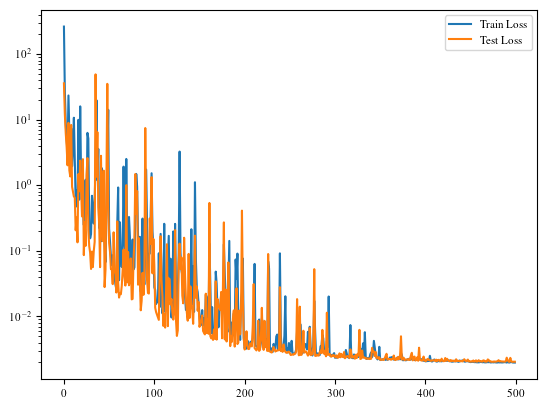

In [24]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        trainLoss += loss(out, y).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        testLoss += loss(out, y).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss/len(testData))
print("Final Training Loss:", trainLoss/len(trainData))

In [99]:
# Set a longer loop for open-loop example as fast to simulate
TOpen = 10
dtOpen = 0.00005
ntOpen = int(round(TOpen/dtOpen))
temporalOpen = np.linspace(0, TOpen, ntOpen)

gamma = 3
init_cond = np.ones(len(spatial))*0.38
uopen, _, _ = solvePDE(init_cond, 1, 1, dtOpen, dtOpen/dx**2, TOpen, gamma, solveBetaFunction, openKernel, openControl, model)
gamma = 5
init_cond = np.ones(len(spatial))*0.04
uopen2, _, _ = solvePDE(init_cond, 1, 1, dtOpen, dtOpen/dx**2, TOpen, gamma, solveBetaFunction, openKernel, openControl, model)

i 20000 / 200000
i 40000 / 200000
i 60000 / 200000
i 80000 / 200000
i 100000 / 200000
i 120000 / 200000
i 140000 / 200000
i 160000 / 200000
i 180000 / 200000
i 20000 / 200000
i 40000 / 200000
i 60000 / 200000
i 80000 / 200000
i 100000 / 200000
i 120000 / 200000
i 140000 / 200000
i 160000 / 200000
i 180000 / 200000


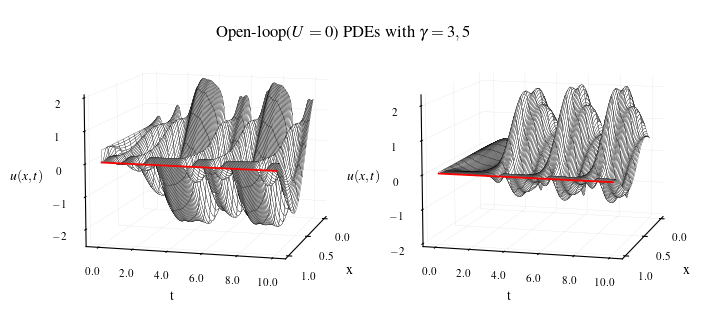

In [100]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,2), height_add=1))
plt.subplots_adjust(left=0.09, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)
subfig = subfigs
subfig.suptitle(r"Open-loop($U=0$) PDEs with $\gamma=3, 5$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporalOpen)

axes[1].plot_surface(meshx, mesht, uopen2, edgecolor="black",lw=0.2, rstride=800, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u(x, t)$")
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
test = np.ones(ntOpen)
vals = (uopen2.transpose())[-1] 
axes[1].plot(test[1:], temporalOpen[1:], vals[1:], color="red", lw=1.3, antialiased=True)
meshx, mesht = np.meshgrid(spatial, temporalOpen)
                     
axes[0].plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=800, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(ntOpen)
vals = (uopen.transpose())[-1] 
axes[0].plot(test[1:], temporalOpen[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u(x, t)$")
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].set_zticks([-2, -1, 0, 1, 2])
axes[1].set_zticks([-2, -1, 0, 1, 2])

#plt.savefig("gainScheduleOpenLoop.pdf", dpi=300)

In [103]:
# This is a true gain scheduling kernel approach. 
gamma = 3
init_cond = np.ones(len(spatial))*0.37
uroa1, kroa1, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
init_cond = np.ones(len(spatial))*0.38
uroa2, kroa2, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
init_cond = np.ones(len(spatial))*0.39
uroa3, kroa3, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
gamma = 5
init_cond = np.ones(len(spatial))*0.03
u2roa1, k2roa1, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
init_cond = np.ones(len(spatial))*0.04
u2roa2, k2roa2, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
init_cond = np.ones(len(spatial))*0.05
u2roa3, k2roa3, _ = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)

i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000


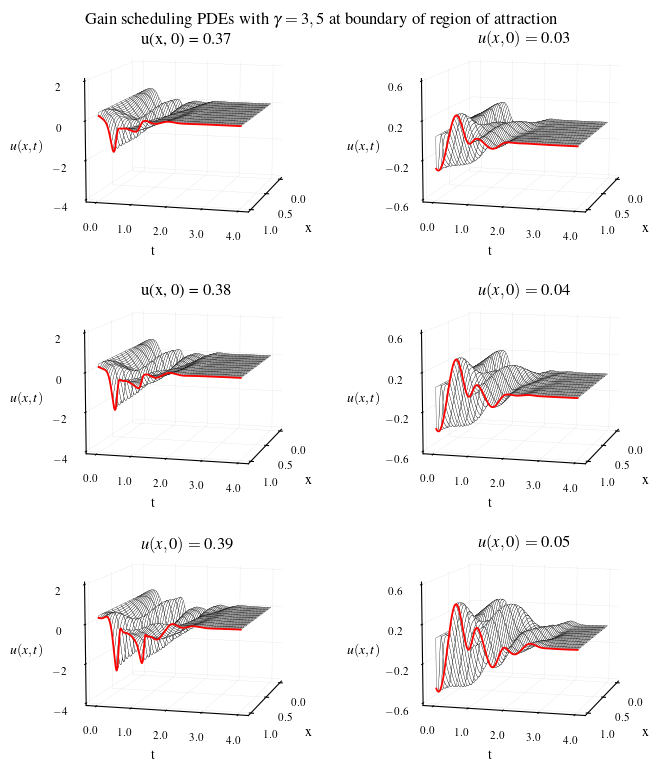

In [121]:
# TRUE SOLUTION PLOTS
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (3,2), height_add=1))
plt.subplots_adjust(left=0.09, bottom=0, right=1, top=.99, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Gain scheduling PDEs with $\gamma=3, 5$ at boundary of region of attraction")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, uroa1, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uroa1.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u(x, t)$")
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, u2roa1, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u2roa1.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u(x, t)$")
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].text(0, 0, 3, r"u(x, 0) = 0.37", fontsize=12)
axes[0].set_zticks([-4, -2, 0, 2])
axes[1].set_zticks([-0.6, -0.2, 0.2, 0.6])
axes[1].text(0, 0, 0.82, r"$u(x, 0) = 0.03$", fontsize=12)

subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, uroa2, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uroa2.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u(x, t)$")
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, u2roa2, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u2roa2.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u(x, t)$")
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].text(0, 0, 3, r"u(x, 0) = 0.38", fontsize=12)
axes[0].set_zticks([-4, -2, 0, 2])
axes[1].set_zticks([-0.6, -0.2, 0.2, 0.6])
axes[1].text(0, 0, 0.82, r"$u(x, 0) = 0.04$", fontsize=12)

subfig = subfigs[2]
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, uroa3, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uroa3.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u(x, t)$")
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, u2roa3, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u2roa3.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u(x, t)$")
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].text(0, 0, 3, r"$u(x, 0) = 0.39$", fontsize=12)
axes[0].set_zticks([-4, -2, 0, 2])
axes[1].set_zticks([-0.6, -0.2, 0.2, 0.6])
axes[1].text(0, 0, 0.82, r"$u(x, 0) = 0.05$", fontsize=12)

plt.savefig("gainScheduleROA.pdf", dpi=300)

In [106]:
# Explore just using a typical backstepping controller
gamma = 3
beta = solveBetaFunction(spatial, gamma, 0)
init_cond = np.ones(len(spatial))*0.38

kernel, _ = solveKernelFunction(beta, beta, beta)
uLinear = solvePDENoSchedule(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, kernel, solveControl, model)

gamma = 5
beta = solveBetaFunction(spatial, gamma, 0)
init_cond = np.ones(len(spatial))*0.04

kernel, _ = solveKernelFunction(beta, beta, beta)
u2Linear = solvePDENoSchedule(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, kernel, solveControl, model)

i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000


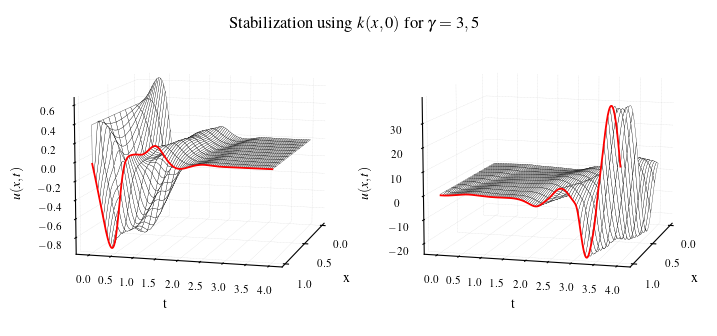

In [120]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,2), height_add=1))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.suptitle(r"Stabilization using $k(x, 0)$ for $\gamma=3, 5$")
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes[0].plot_surface(meshx, mesht, uLinear, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u(x, t)$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
test = np.ones(nt)
vals = (uLinear.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)

axes[1].plot_surface(meshx, mesht, u2Linear, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u(x, t)$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
test = np.ones(nt)
vals = (u2Linear.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)


plt.savefig("gainScheduleStabilization.pdf", dpi=300)

In [108]:
# Solve with NOP Kernels
gamma = 3
init_cond = np.ones(len(spatial))*0.38
u, k, utime = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
uhat, khat, utimehat = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunctionTorch, solveControl, model)

gamma = 5
init_cond = np.ones(len(spatial))*0.04
u2, k2, utime2 = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunction, solveControl, model)
uhat2, khat2, utimehat2 = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, gamma, solveBetaFunction, solveKernelFunctionTorch, solveControl, model)

i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000
i 40000 / 400000
i 80000 / 400000
i 120000 / 400000
i 160000 / 400000
i 200000 / 400000
i 240000 / 400000
i 280000 / 400000
i 320000 / 400000
i 360000 / 400000


In [109]:
# Convert to numpy and loop at time comparisons
k = np.array(k)
khat = np.array(khat)
k2 = np.array(k2)
khat2 = np.array(khat2)

print("time u:", utime)
print("time uhat:", utimehat)
print("time u2:", utime2)
print("time uhat2:", utimehat2)

time u: 177.38396286964417
time uhat: 100.70003604888916
time u2: 176.04264044761658
time uhat2: 102.20955634117126


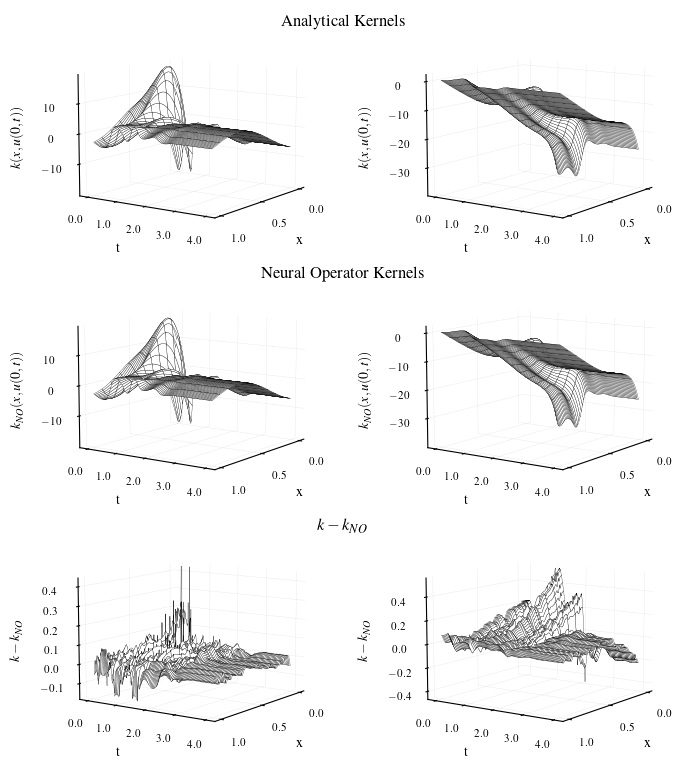

In [116]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (3,2), height_add=1))

subfigs = fig.subfigures(nrows=3, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Analytical Kernels")
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])

axes[0].plot_surface(meshx, mesht, k, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 35)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$k(x, u(0, t))$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, k2, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 35)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$k(x, u(0, t))$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[1]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"Neural Operator Kernels")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes[0].plot_surface(meshx, mesht, khat, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 35)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$k_{NO}(x, u(0, t))$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, khat2, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 35)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$k_{NO}(x, u(0, t))$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

subfig = subfigs[2]
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

subfig.suptitle(r"$k-k_{NO}$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal[1:])
                     
axes[0].plot_surface(meshx, mesht, k-khat, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[0].view_init(10, 35)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$k-k_{NO}$", rotation=90)
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes[1].plot_surface(meshx, mesht, k2-khat2, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 35)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$k-k_{NO}$", rotation=90)
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("gainScheduleKernel.pdf", dpi=300)

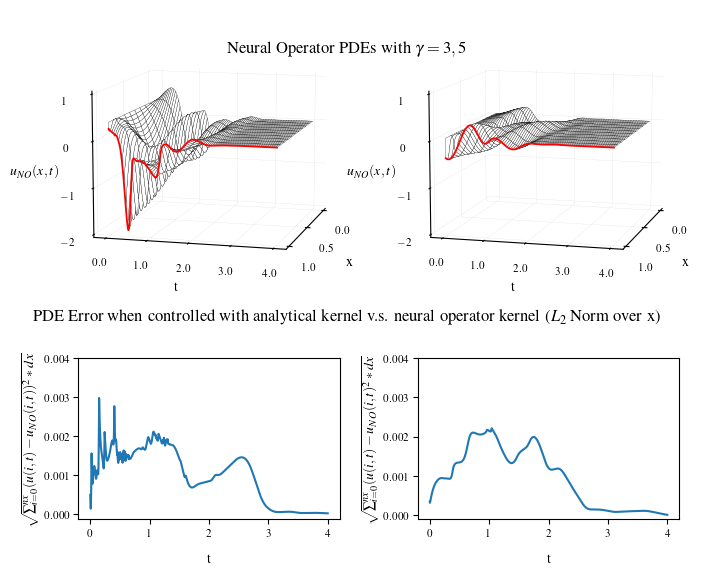

In [118]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2,2), height_add=1))
plt.subplots_adjust(left=0.09, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)

subfig = subfigs[0]
subfig.suptitle(r"Neural Operator PDEs with $\gamma=3, 5$")
axes = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((0, 0, 0))
    
meshx, mesht = np.meshgrid(spatial, temporal)

axes[1].plot_surface(meshx, mesht, uhat2, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes[1].view_init(10, 15)
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
axes[1].set_zlabel(r"$u_{NO}(x, t)$")
axes[1].zaxis.set_rotate_label(False)
axes[1].set_xticks([0, 0.5, 1])
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
test = np.ones(nt)
vals = (uhat2.transpose())[-1] 
axes[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)

                     
axes[0].plot_surface(meshx, mesht, uhat, edgecolor="black",lw=0.2, rstride=4000, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (uhat.transpose())[-1] 
axes[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes[0].view_init(10, 15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
axes[0].set_zlabel(r"$u_{NO}(x, t)$")
axes[0].zaxis.set_rotate_label(False)
axes[0].set_xticks([0, 0.5, 1])
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[0].set_zticks([-2, -1, 0, 1])
axes[1].set_zticks([-2, -1, 0, 1])


subfig = subfigs[1]
zticks = [0, 0.25, 0.5, 0.75, 1]
subfig.suptitle(r"PDE Error when controlled with analytical kernel v.s. neural operator kernel ($L_2$ Norm over x)")
ax = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.12, bottom=0.2, right=.97, top=0.8, wspace=0.3, hspace=0.1)
ax[0].plot(temporal[:-1], getPDEl2(u, uhat))
ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
ax[0].set_xlabel("t", labelpad=10)
ax[0].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u(i, t) - u_{NO}(i, t))^2*dx}$")
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ax[1].plot(temporal[:-1], getPDEl2(u2, uhat2))
ax[1].ticklabel_format(style='sci',scilimits=(-4,5),axis='both')
ax[1].set_xlabel("t", labelpad=10)
ax[1].set_ylabel(r"$\sqrt{\sum_{i=0}^{nx} (u(i, t) - u_{NO}(i, t)^2*dx}$")
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax[1].set_yticks([0, 0.001, 0.002, 0.003, 0.004])
ax[0].set_yticks([0, 0.001, 0.002, 0.003, 0.004])

plt.savefig("gainScheduleNOP.pdf", dpi=300)

In [32]:
# Speedup calculations
# dx=0.01
X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)

dim_x = 1
m = len(spatial)+1
grid = np.reshape(spatial, (100, 1))
grid = np.array(grid, dtype=np.float32)
grid = torch.from_numpy(grid).cuda()


model = dde.nn.DeepONetCartesianProd([m, 512, 256, 256], [dim_x, 128, 256], "relu", "Glorot normal").cuda()
beta = solveBetaFunction(spatial, 5, 0)

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, beta, beta)
    timeSum += (time.time()-x)
print("Analytical time", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunctionTorch(beta, 1, model)
    timeSum2 += (time.time()-x)
print("NOP time", timeSum2/100)
print("Speedup", timeSum/timeSum2)

282625
0.0004368400573730469
0.0002860450744628906
1.527172101086884


In [122]:
# dx=0.001
X = 1
dx = 0.001
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)

dim_x = 1
m = len(spatial)+1
grid = np.reshape(spatial, (1000, 1))
grid = np.array(grid, dtype=np.float32)
grid = torch.from_numpy(grid).cuda()


model = dde.nn.DeepONetCartesianProd([m, 512, 256, 256], [dim_x, 128, 256], "relu", "Glorot normal").cuda()
beta = solveBetaFunction(spatial, 5, 0)

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, beta, beta)
    timeSum += (time.time()-x)
print("Analytical time", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunctionTorch(beta, 1, model)
    timeSum2 += (time.time()-x)
print("NOP time", timeSum2/100)
print("Speedup", timeSum/timeSum2)

Analytical time 0.0262965989112854
NOP time 0.00029973745346069337
Speedup 87.73210890955225


In [123]:
# dx=0.0005
X = 1
dx = 0.0005
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)

dim_x = 1
m = len(spatial)+1
grid = np.reshape(spatial, (2000, 1))
grid = np.array(grid, dtype=np.float32)
grid = torch.from_numpy(grid).cuda()


model = dde.nn.DeepONetCartesianProd([m, 512, 256, 256], [dim_x, 128, 256], "relu", "Glorot normal").cuda()
beta = solveBetaFunction(spatial, 5, 0)

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, beta, beta)
    timeSum += (time.time()-x)
print("Analytical time", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunctionTorch(beta, 1, model)
    timeSum2 += (time.time()-x)
print("NOP time", timeSum2/100)
print("Speedup", timeSum/timeSum2)

Analytical time 0.10038903713226319
NOP time 0.0003102397918701172
Speedup 323.58530324920844


In [124]:
# dx=0.0001
X = 1
dx = 0.0001
nx = int(round(X/dx))
spatial = np.linspace(dx, X, nx)

dim_x = 1
m = len(spatial)+1
grid = np.reshape(spatial, (10000, 1))
grid = np.array(grid, dtype=np.float32)
grid = torch.from_numpy(grid).cuda()


model = dde.nn.DeepONetCartesianProd([m, 512, 256, 256], [dim_x, 128, 256], "relu", "Glorot normal").cuda()
beta = solveBetaFunction(spatial, 5, 0)

timeSum = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunction(beta, beta, beta)
    timeSum += (time.time()-x)
print("Analytical time", timeSum/100)

timeSum2 = 0
for i in range(100):
    x = time.time()
    kappa = solveKernelFunctionTorch(beta, 1, model)
    timeSum2 += (time.time()-x)
print("NOP time", timeSum2/100)
print("Speedup", timeSum/timeSum2)

Analytical time 2.508096528053284
NOP time 0.0005412578582763671
Speedup 4633.829310192935
